First, we'll obtain the single-peak Gaussian signals that we randomly generated. This will be the simplest test case for this RNN method, and we'll build the complexity from here.

In [185]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import random
import torch

In [186]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [187]:
# try making Gauss peaks more narrow

In [188]:
# path = 'saved_data/math_functions_single.nc'
path = 'saved_data/math_functions_single_narrow.nc'

# Load .nc file
ds = xr.open_dataset(path)

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))
for j in range(binary.shape[0]):
    idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
    binary[j][idx - 2] = 1
    binary[j][idx - 1] = 1
    binary[j][idx + 1] = 1
    binary[j][idx + 2] = 1

x = ds["x"].values

<class 'numpy.ndarray'>


In [189]:
binary.shape

(10000, 500)

Visualize some of the randomly generated Gaussian signals with single peaks.

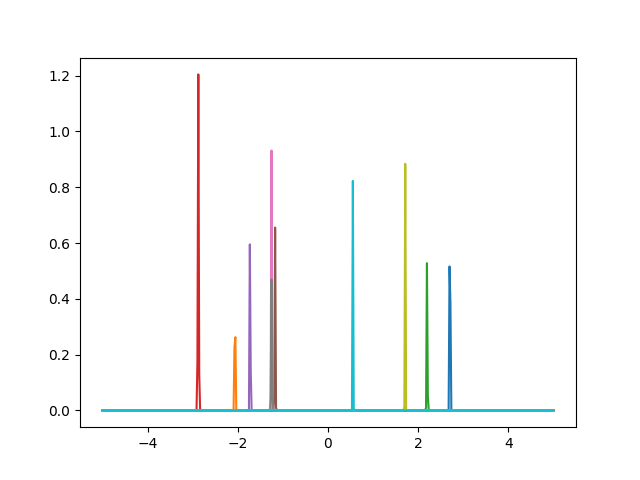

In [190]:
plt.figure()

for i in range(10):
    plt.plot(x, gaussians[i])

# adding noise: Dan says to add it to improve perfromance
# any weight in NN times 0 is 0. ideally what this is learning is a series of weights with behavior you want
# problem with 0 is that it's so sharp that those weights don't behave
# noise level of 0.05 or smth poisson distribution

In [191]:
import torch
import torch.nn as nn

In [192]:
sequence_length = 500 # num of x values
input_size = 2 # 2 because we have (x, intensity) coordinates, which are 2 features

# input shape should be: (batch_size, sequence_length, input_size)
batch_size = 32 # can make batch size = 5?

In [193]:
i = 1 
peak_idx = gaussians[i].argmax()
peak_x = x[peak_idx]

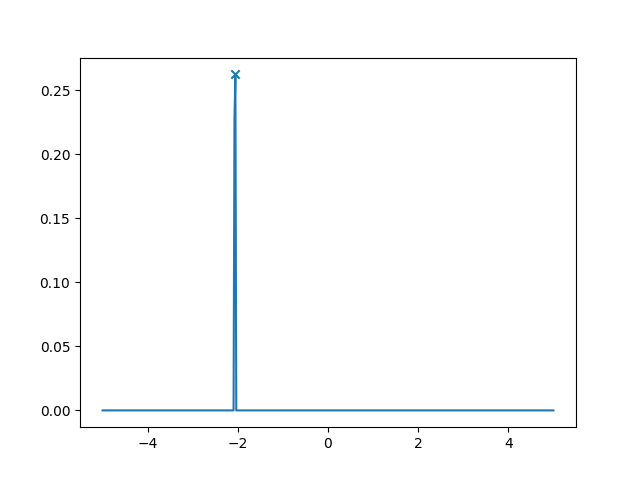

In [194]:
peak_idx
plt.figure()
plt.scatter(peak_x, gaussians[i][peak_idx], marker='x')
plt.plot(x, gaussians[i])

In [195]:
import torch.optim as optim

In [196]:
total_num = gaussians.shape[0]

all_x_arrs = []
for _ in range(total_num):
    all_x_arrs.append(x)

all_xs = np.stack(all_x_arrs, axis=0)
all_xs.shape

(10000, 500)

In [197]:
# data shape: (batch_size, sequence_length, input_size)
# make data tensor
# ()
print(all_xs.shape)
print(gaussians.shape)

(10000, 500)
(10000, 500)


In [198]:
gaussians[0]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [199]:
from torch.utils.data import DataLoader, TensorDataset

In [200]:
all_data = torch.from_numpy(np.stack((all_xs, gaussians), axis=-1).astype(np.float32)) # shape = (1000, 500, 2)
binary = torch.from_numpy(binary)
print(all_data.shape)
print(binary.shape)

torch.Size([10000, 500, 2])
torch.Size([10000, 500])


In [201]:
from sklearn.model_selection import train_test_split

tv_X, test_X, tv_y, test_y = train_test_split(all_data, binary, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(tv_X, tv_y, test_size = 0.25, shuffle=False)

In [202]:
train_X = train_X.float()
val_X = val_X.float()
test_X = test_X.float()

train_y = train_y.float()
val_y = val_y.float()
test_y = test_y.float()

In [203]:
train_ds = TensorDataset(train_X, train_y)
val_ds = TensorDataset(val_X, val_y)
test_ds = TensorDataset(test_X, test_y)

In [204]:
train_ds.tensors

(tensor([[[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         ...,
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000

In [205]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [206]:
class PeakFinderRNN(nn.Module):
    # maybe should make input size 2? idk ...
    def __init__(self, input_size=input_size, hidden_size=64, num_layers=1, output_size=1):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # output_size=1 
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        logits = self.fc(rnn_out)  # Predict peak position
        return logits.squeeze(-1)  # shape: (batch,)

In [207]:
model = PeakFinderRNN()
pos_weight = torch.tensor([100.0])  # e.g., ratio of 1/0 samples
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [208]:
num_epochs = 30
train_loss = [] 
val_loss = []

for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}/{num_epochs}')

    model.train() # train the model
    epoch_train_loss = 0.0 # record training loss for this epoch

    for x, y in train_loader:
        pred_y = model(x) # predict a label
        loss = criterion(pred_y, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Average the training loss over all batches
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    print(f'Average training loss = {avg_train_loss}')

    # all_preds = []
    # all_labels = []

    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for xval, yval in val_loader:
            logits = model(xval)  # raw output
            probs = torch.sigmoid(logits)  # convert logits to probabilities
            loss = criterion(logits, yval)

            epoch_val_loss += loss.item()
        
        # Average the validation loss over all batches
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        print(f'Average validation loss = {avg_val_loss}')
    
    # print(f'Epoch {epoch}/{num_epochs}. Train_loss = {train_loss:.4f} and val loss = {val_loss:.4f}')

Starting epoch 1/30
Average training loss = 1.1121413289232458
Average validation loss = 0.9908580988172501
Starting epoch 2/30
Average training loss = 0.8139998817697485
Average validation loss = 0.6955668907316904
Starting epoch 3/30
Average training loss = 0.8784212669793595
Average validation loss = 1.9121259413068257
Starting epoch 4/30
Average training loss = 0.9814010969501861
Average validation loss = 0.6884545390568082
Starting epoch 5/30
Average training loss = 1.0126794684440532
Average validation loss = 1.0151078701019287
Starting epoch 6/30
Average training loss = 0.8555458559000746
Average validation loss = 0.7652141120698717
Starting epoch 7/30
Average training loss = 0.7150935949163234
Average validation loss = 0.65273151038185
Starting epoch 8/30
Average training loss = 0.5742537945191911
Average validation loss = 0.5041337632943713
Starting epoch 9/30
Average training loss = 0.48128312239621546
Average validation loss = 0.46150987488882883
Starting epoch 10/30
Average

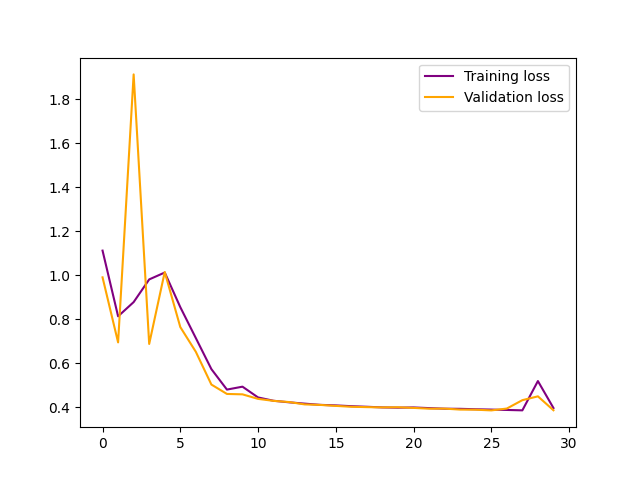

In [209]:
plt.close('all')
plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss, color='purple', label='Training loss')
plt.plot(np.arange(len(val_loss)), val_loss, color='orange', label='Validation loss')
plt.legend()
plt.show()

In [210]:
# Test the model
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for xtest, ytest in test_loader:
        logits = model(xtest)
        loss = criterion(logits, ytest)
        test_loss += loss.item()

        probs = torch.sigmoid(logits)
        all_preds.append(probs)
        all_labels.append(ytest)

avg_test_loss = test_loss / len(test_loader)
print(avg_test_loss)

0.38312860140724786


In [211]:
all_labels_2 = torch.cat(all_labels).cpu().numpy()
all_preds_2 = torch.cat(all_preds).cpu().numpy()

In [212]:
plt.close('all')

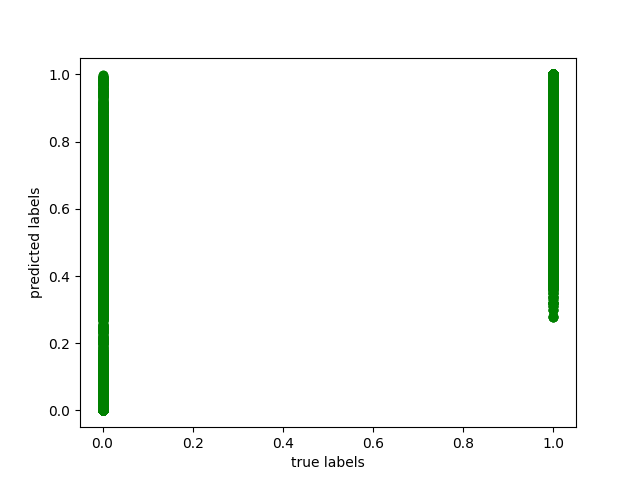

In [213]:
plt.figure()
plt.scatter(all_labels_2, all_preds_2, color='green')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

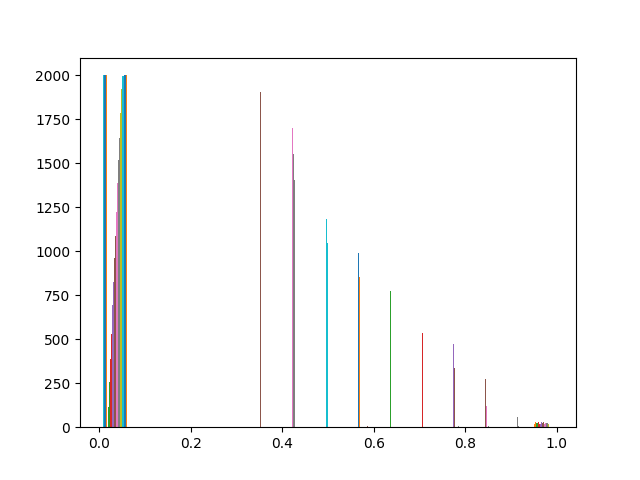

In [214]:
# visualize the distribution better
plt.figure()
plt.hist(all_preds_2, bins=15)
plt.show()

In [215]:
rounded_labels_pred = np.round(all_preds_2)
print(rounded_labels_pred.shape)

(2000, 500)


In [216]:
rounded_labels_true = np.round(all_labels_2)


In [217]:
all_0 = []
all_1 = []
all_1_idx_pred = []

In [218]:
all_0_true = []
all_1_true = []

In [219]:
for j in range(rounded_labels_pred.shape[0]):
    count_0 = 0
    count_1 = 0
    count_0_true = 0
    count_1_true = 0
    for i in rounded_labels_pred[j]:
        if int(i) == 0:
            count_0 += 1
        if int(i) == 1:
            count_1 += 1
    for i in rounded_labels_true[j]:
        if int(i) == 0:
            count_0_true += 1
        if int(i) == 1:
            count_1_true += 1
    

    all_0.append(count_0)
    all_1.append(count_1)
    all_0_true.append(count_0_true)
    all_1_true.append(count_1_true)

print(all_0)
print(all_1)
print(all_0_true)
print(all_1_true)

[432, 496, 497, 496, 413, 495, 496, 373, 358, 496, 466, 382, 496, 340, 497, 496, 365, 443, 437, 496, 477, 374, 410, 496, 473, 334, 487, 388, 387, 496, 497, 416, 495, 454, 497, 497, 495, 481, 497, 496, 398, 415, 496, 497, 496, 496, 497, 345, 357, 380, 496, 445, 334, 431, 337, 496, 496, 496, 496, 354, 398, 442, 496, 360, 496, 422, 496, 412, 496, 497, 461, 496, 490, 497, 495, 496, 399, 496, 497, 423, 418, 401, 383, 428, 472, 358, 482, 459, 466, 427, 328, 496, 348, 445, 379, 420, 441, 497, 496, 496, 397, 352, 410, 350, 496, 496, 403, 497, 496, 497, 496, 496, 496, 451, 357, 336, 486, 444, 412, 497, 496, 496, 341, 496, 496, 417, 496, 386, 496, 386, 497, 406, 437, 375, 496, 496, 490, 442, 439, 389, 343, 484, 470, 436, 496, 455, 358, 439, 497, 364, 417, 467, 446, 495, 435, 497, 437, 386, 497, 340, 341, 471, 496, 496, 357, 497, 491, 497, 496, 496, 334, 496, 353, 397, 496, 496, 496, 496, 497, 496, 496, 496, 496, 440, 397, 349, 495, 392, 436, 390, 476, 384, 442, 496, 343, 393, 447, 495, 401, 417,

In [220]:
print(rounded_labels_pred[3])
print(rounded_labels_true[3])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [221]:
x_vals = ds['x'].values

predicted: [-0.43086172 -0.41082164 -0.39078156 -0.37074148 -0.3507014  -0.33066132
 -0.31062124 -0.29058116 -0.27054108 -0.250501   -0.23046092 -0.21042084
 -0.19038076 -0.17034068 -0.1503006  -0.13026052 -0.11022044 -0.09018036
 -0.07014028 -0.0501002  -0.03006012 -0.01002004  0.01002004  0.03006012
  0.0501002   0.07014028  0.09018036  0.11022044  0.13026052  0.1503006
  0.17034068  0.19038076  0.21042084  0.23046092  0.250501    0.27054108
  0.29058116  0.31062124  0.33066132  0.3507014   0.37074148  0.39078156
  0.41082164  0.43086172  0.4509018   0.47094188  0.49098196  0.51102204
  0.53106212  0.5511022   0.57114228  0.59118236  0.61122244  0.63126253
  0.65130261  0.67134269  0.69138277  0.71142285  0.73146293  0.75150301
  0.77154309  0.79158317  0.81162325  0.83166333  0.85170341  0.87174349
  0.89178357  0.91182365]
true: [0.83166333 0.85170341 0.87174349 0.89178357 0.91182365]
predicted: [-1.73346693 -1.71342685 -1.69338677 -1.67334669]
true: [-1.75350701 -1.73346693 -1.713

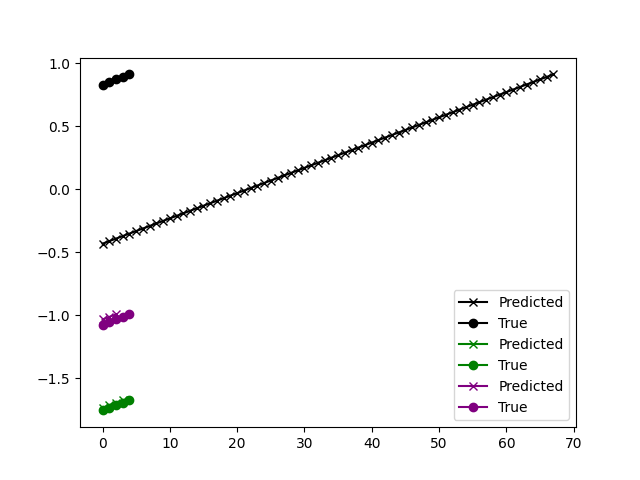

In [222]:
plt.figure()
colors = ['black', 'green', 'purple']

# Visualize how far the predicted peaks are from the real peaks

for sample_idx in range(3):
    pred_idx = np.where(rounded_labels_pred[sample_idx] == 1)[0]
    true_idx = np.where(rounded_labels_true[sample_idx] == 1)[0]

    print(f'predicted: {x_vals[pred_idx]}')
    print(f'true: {x_vals[true_idx]}')

    plt.plot(x_vals[pred_idx], marker='x', label='Predicted', color=colors[sample_idx])
    plt.plot(x_vals[true_idx], marker='o', label='True', color=colors[sample_idx])

plt.legend()
plt.show()